Fetching data for CIK: 0000320193...

Plotting time-series data in separate subplots...


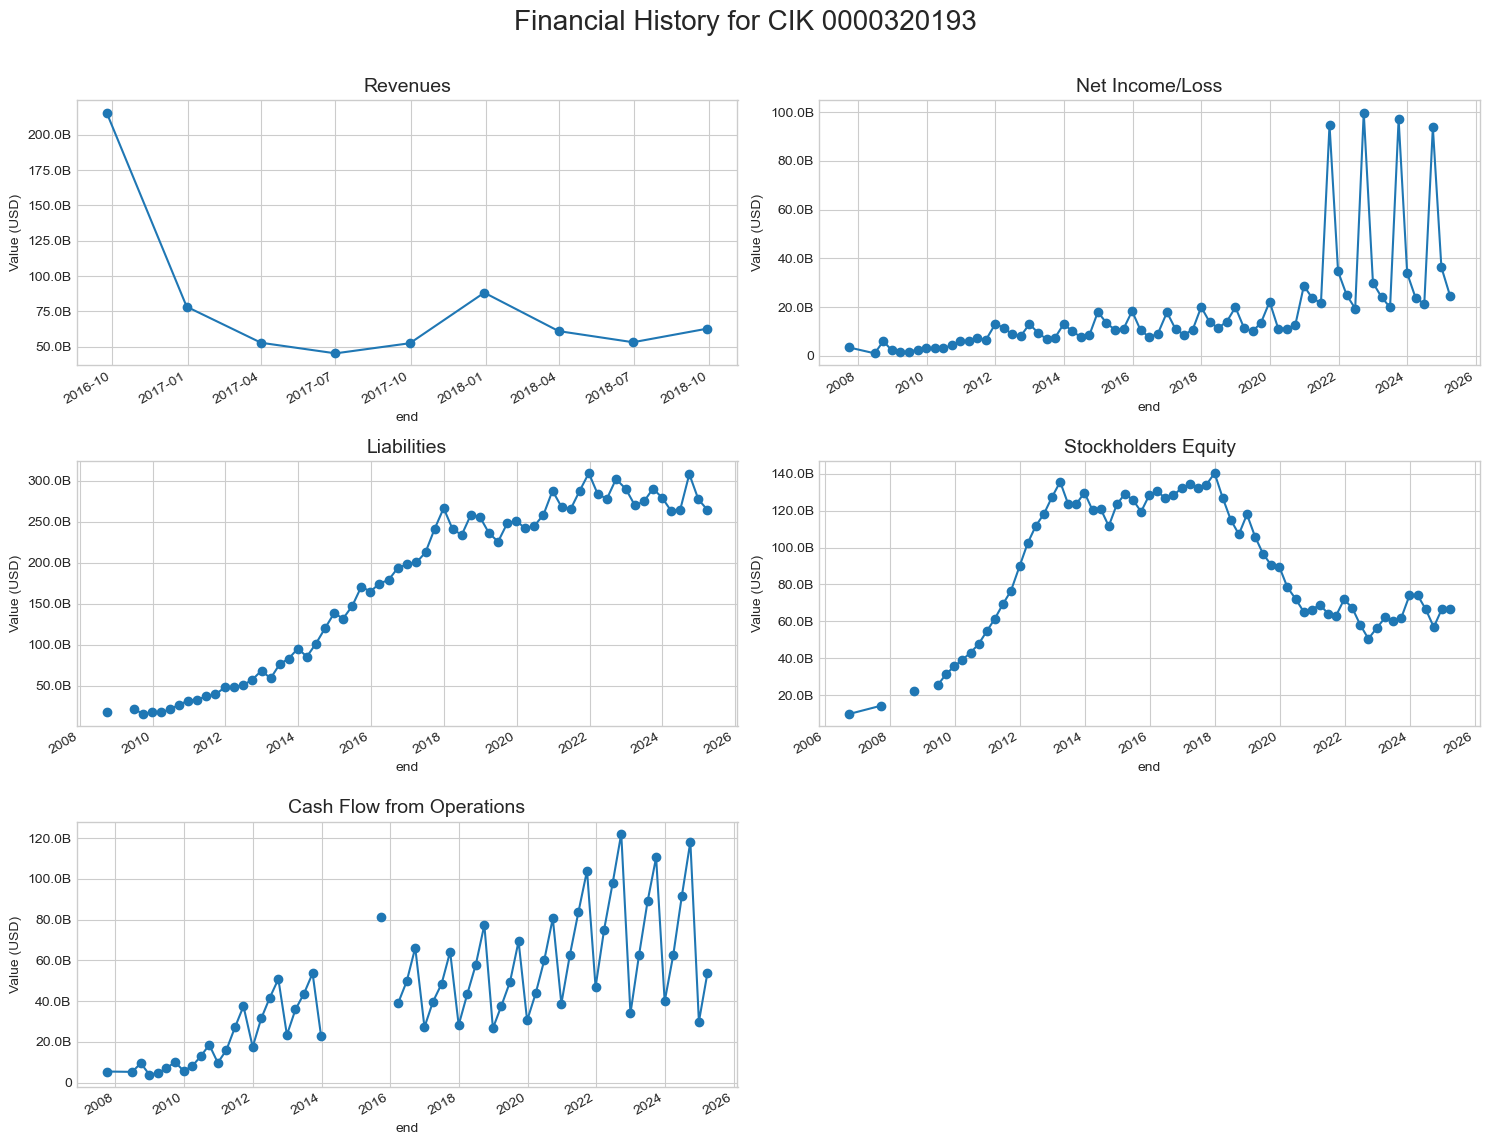


--- Starting Asset Composition Analysis for Last Two Years ---
Found data for Fiscal Years: 2024 and 2023

Plotting asset composition comparison (vertically)...


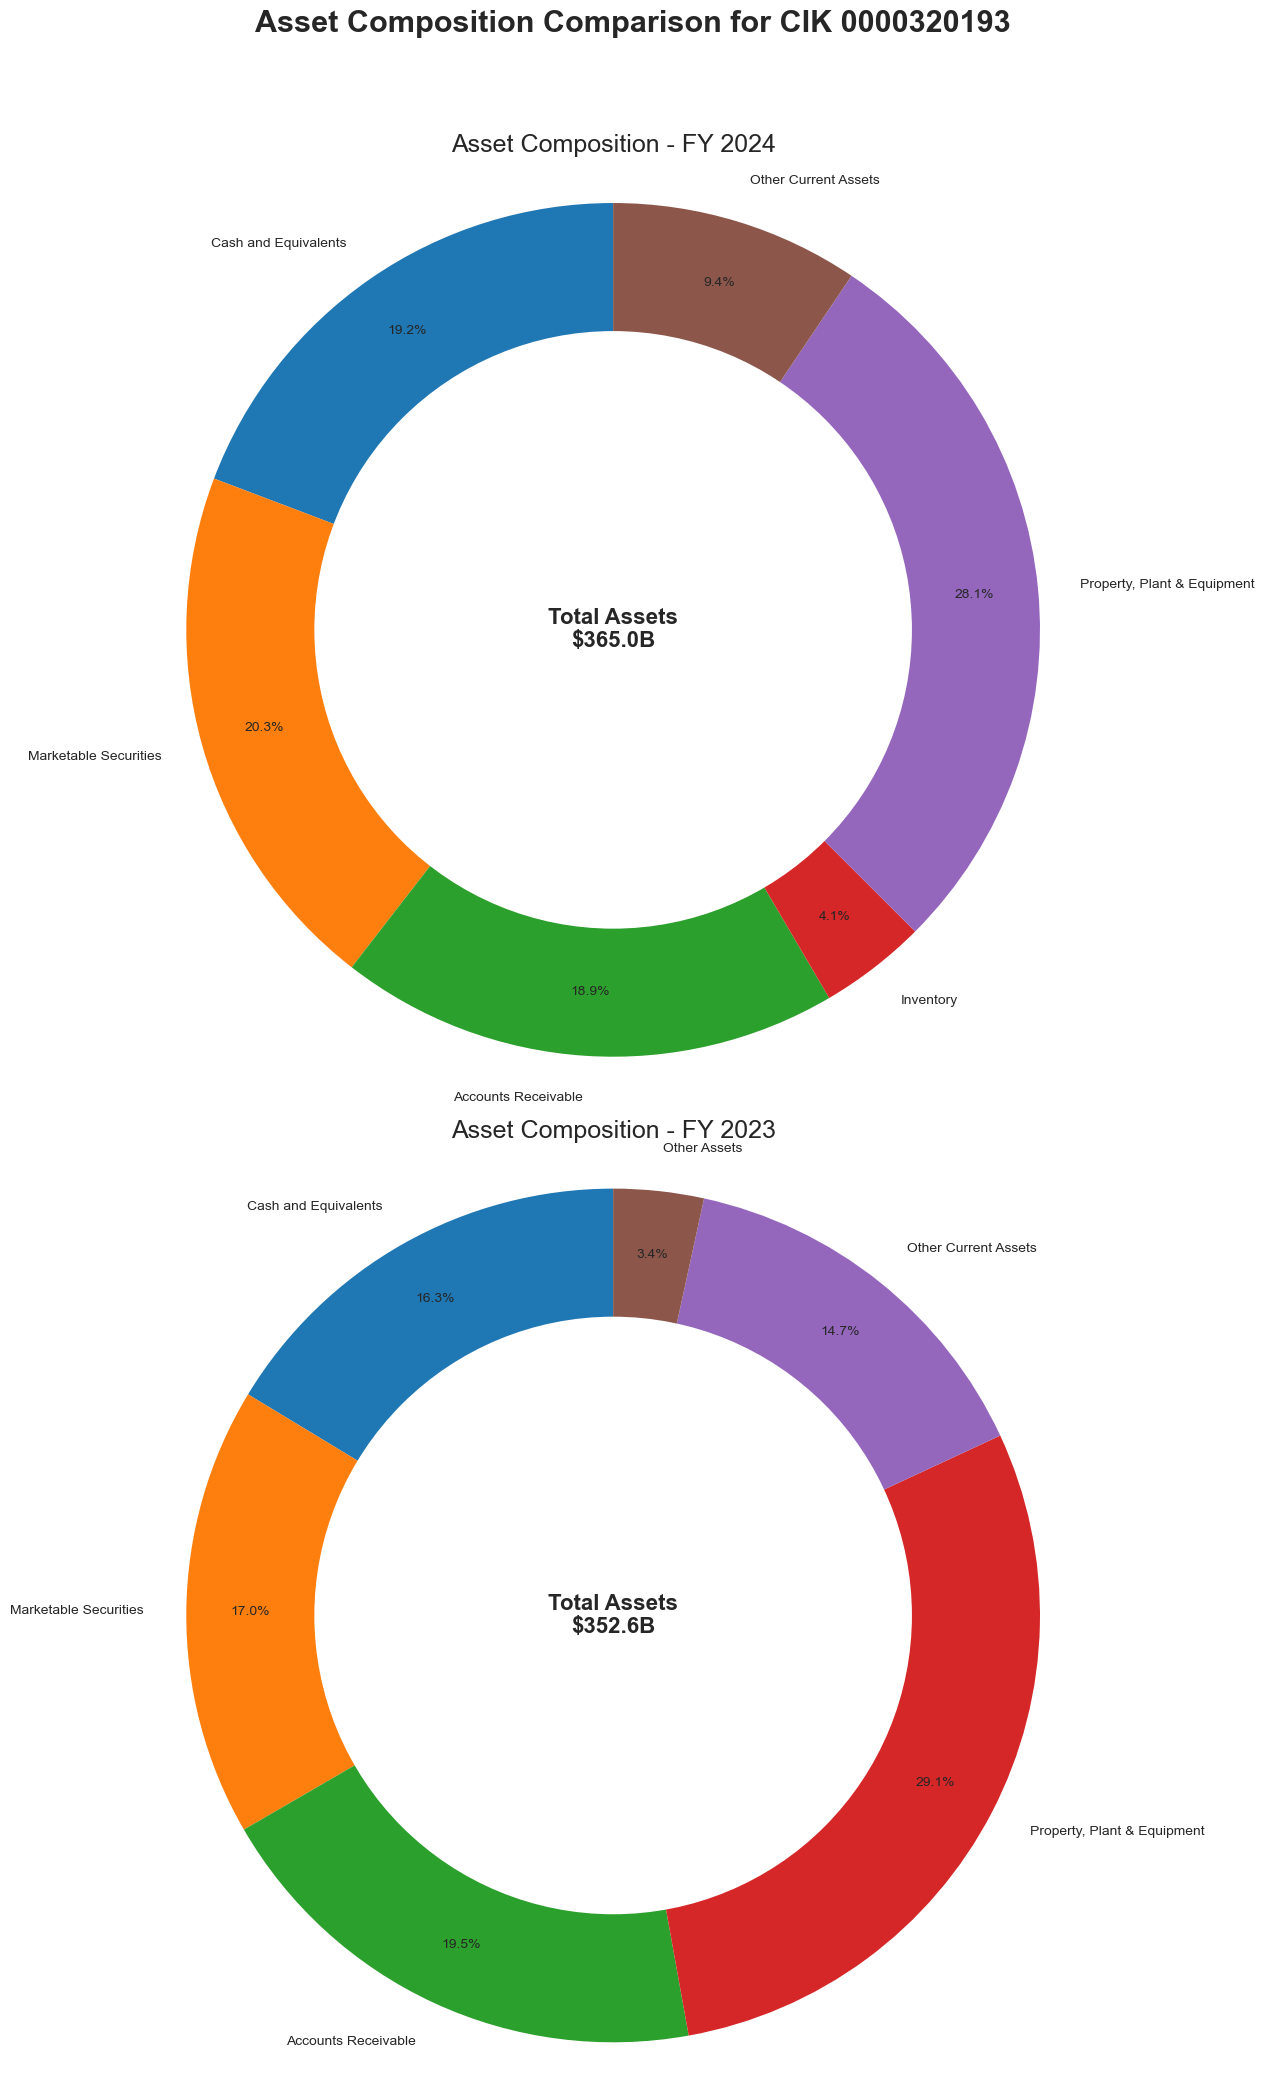

In [27]:
# -*- coding: utf-8 -*-
"""
SEC Filing Scraper - Full Analysis with English Labels
"""

# import modules
import requests
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Settings ---
headers = {'User-Agent': "yourname@yourdomain.com"}
cik = '0000320193' # CIK for Apple Inc.

# English labels for time-series plots
concepts_to_plot = {
    'Revenues': 'Revenues',
    'NetIncomeLoss': 'Net Income/Loss',
    'Liabilities': 'Liabilities',
    'StockholdersEquity': 'Stockholders Equity',
    'NetCashProvidedByUsedInOperatingActivities': 'Cash Flow from Operations'
}

print(f"Fetching data for CIK: {cik}...")
# This initial call is used for both parts of the analysis
companyFacts_response = requests.get(f'https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json', headers=headers)

# --- Part 1: Plotting Time-Series Data in Subplots ---

# We check the response status code here. If it fails, we skip everything.
if companyFacts_response.status_code == 200:
    all_data_frames = []
    
    # Loop through each concept to get its time-series data
    for concept_tag, concept_name in concepts_to_plot.items():
        url = f'https://data.sec.gov/api/xbrl/companyconcept/CIK{cik}/us-gaap/{concept_tag}.json'
        response = requests.get(url, headers=headers)
        
        if response.status_code == 200 and 'units' in response.json() and 'USD' in response.json()['units']:
            df = pd.DataFrame.from_dict(response.json()['units']['USD'])
            df = df[['end', 'val', 'form']]
            df = df[df['form'].isin(['10-Q', '10-K'])].copy()
            df['end'] = pd.to_datetime(df['end'])
            df['val'] = pd.to_numeric(df['val'])
            df = df.drop_duplicates(subset='end', keep='last')
            df = df.rename(columns={'val': concept_name}).set_index('end')[concept_name]
            all_data_frames.append(df)
        else:
            print(f"--> Could not fetch time-series data for: {concept_name}")

    if all_data_frames:
        combined_df = pd.concat(all_data_frames, axis=1).sort_index()

        print("\nPlotting time-series data in separate subplots...")
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
        axes = axes.flatten() 

        for i, column in enumerate(combined_df.columns):
            ax = axes[i]
            combined_df[column].plot(ax=ax, marker='o', linestyle='-')
            ax.set_title(column, fontsize=14)
            ax.set_ylabel('Value (USD)')
            ax.grid(True)
            ax.yaxis.set_major_formatter(lambda x, pos: f'{x/1e9:.1f}B' if x != 0 else '0')

        # Hide any unused subplots
        for i in range(len(combined_df.columns), len(axes)):
            fig.delaxes(axes[i])
            
        fig.suptitle(f'Financial History for CIK {cik}', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show() # This shows the first figure with line charts

    # --- Part 2: Asset Composition Analysis for Last Two Years (Vertical Donut Charts) ---

    print("\n--- Starting Asset Composition Analysis for Last Two Years ---")

    # English labels for asset components
    common_asset_tags = {
        'CashAndCashEquivalentsAtCarryingValue': 'Cash and Equivalents',
        'MarketableSecuritiesCurrent': 'Marketable Securities',
        'AccountsReceivableNetCurrent': 'Accounts Receivable',
        'InventoryNet': 'Inventory',
        'PropertyPlantAndEquipmentNet': 'Property, Plant & Equipment',
        'Goodwill': 'Goodwill',
        'IntangibleAssetsNetExcludingGoodwill': 'Intangible Assets',
        'OtherAssetsCurrent': 'Other Current Assets'
    }

    # Helper function to find the value for a specific fiscal year from a list of filings
    def get_value_for_year(filings, target_fy):
        for entry in filings:
            if entry.get('form') == '10-K' and entry.get('fy') == target_fy:
                return entry['val']
        return 0

    companyFacts = companyFacts_response.json()
    us_gaap_facts = companyFacts.get('facts', {}).get('us-gaap', {})

    if 'Assets' in us_gaap_facts and 'USD' in us_gaap_facts['Assets']['units']:
        assets_data = us_gaap_facts['Assets']['units']['USD']
        annual_reports = sorted([r for r in assets_data if r['form'] == '10-K'], key=lambda x: x['end'], reverse=True)
        
        if len(annual_reports) >= 2:
            latest_report = annual_reports[0]
            previous_report = annual_reports[1]
            
            fy1, total_assets_y1 = latest_report['fy'], latest_report['val']
            fy2, total_assets_y2 = previous_report['fy'], previous_report['val']

            print(f"Found data for Fiscal Years: {fy1} and {fy2}")

            asset_breakdown_y1, asset_breakdown_y2 = {}, {}
            for tag, name in common_asset_tags.items():
                if tag in us_gaap_facts:
                    all_filings = us_gaap_facts[tag]['units']['USD']
                    val_y1 = get_value_for_year(all_filings, fy1)
                    if val_y1 > 0: asset_breakdown_y1[name] = val_y1
                    val_y2 = get_value_for_year(all_filings, fy2)
                    if val_y2 > 0: asset_breakdown_y2[name] = val_y2
            
            def create_donut_chart(ax, data, total_assets, year_title):
                total_components = sum(data.values())
                threshold = 0.04 * total_components
                main_slices = {label: val for label, val in data.items() if val >= threshold}
                other_sum = sum(val for val in data.values() if val < threshold)
                if other_sum > 0: main_slices['Other Assets'] = other_sum

                ax.pie(main_slices.values(), autopct='%1.1f%%', startangle=90, pctdistance=0.85, labels=main_slices.keys())
                centre_circle = plt.Circle((0, 0), 0.70, fc='white')
                ax.add_artist(centre_circle)
                total_assets_str = f'${total_assets/1e9:.1f}B'
                ax.text(0, 0, f'Total Assets\n{total_assets_str}', ha='center', va='center', fontsize=16, weight='bold')
                ax.set_title(f'Asset Composition - FY {year_title}', fontsize=18)
                ax.axis('equal')

            print("\nPlotting asset composition comparison (vertically)...")
            # Create a figure with 2 rows and 1 column for vertical plotting
            fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 22))
            
            create_donut_chart(axes[0], asset_breakdown_y1, total_assets_y1, fy1)
            create_donut_chart(axes[1], asset_breakdown_y2, total_assets_y2, fy2)
            
            fig.suptitle(f'Asset Composition Comparison for CIK {cik}', fontsize=22, weight='bold')
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show() # This shows the second figure with donut charts

        else:
            print("\nCould not find at least two annual reports to compare.")
    else:
        print("\nCould not find 'Assets' data to perform composition analysis.")

else:
    print(f"\nCould not fetch company facts (Status Code: {companyFacts_response.status_code}). Skipping all plotting.")